In [1]:
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2

In [2]:
import os

os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

!git clone https://github.com/yiskw713/ScoreCAM.git

fatal: destination path 'ScoreCAM' already exists and is not an empty directory.


In [3]:
%cd /project/validating_attribution_techniques/saikat/ScoreCAM

/project/validating_attribution_techniques/saikat/ScoreCAM


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
ngpu = torch.cuda.device_count()
for gpu_id in range(ngpu):
    gpu = torch.cuda.get_device_name(gpu_id)
    print(f"GPU:{gpu_id} {gpu}")

GPU:0 NVIDIA GeForce RTX 2080 Ti
GPU:1 NVIDIA GeForce RTX 2080 Ti


In [5]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
# from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

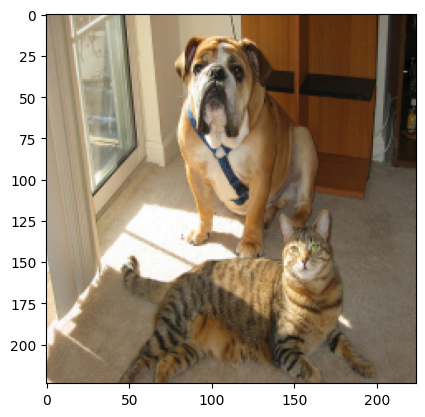

In [6]:
image = Image.open('/project/validating_attribution_techniques/commons/examples/input.png')
imshow(image)

In [7]:
# Resize the image
size = (300, 300)
image = image.resize(size)

In [8]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [9]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)

Using cache found in /home/smitra/.cache/torch/hub/pytorch_vision_v0.10.0
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch/smitra/python/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
gpu_reference_tensor = next(model.parameters())
tensor = tensor.type_as(gpu_reference_tensor)

In [11]:
target_layer = model.layer4[1].conv2
wrapped_model1 = ScoreCAM(model, target_layer)
wrapped_model2 = SmoothGradCAMpp(model, target_layer, n_samples=25, stdev_spread=0.15)
cam, idx = wrapped_model1(tensor)

bucket, pail
463


Text(0.5, 1.0, 'Class: bucket, pail')

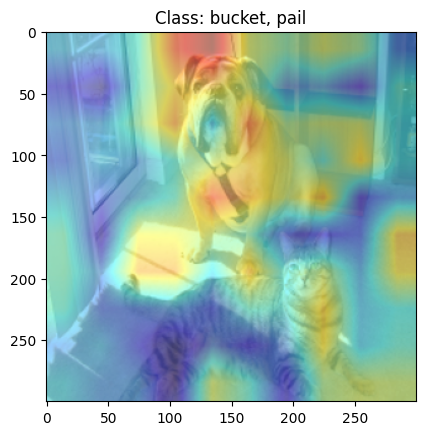

In [12]:
fig, ax = plt.subplots()
print(idx2label[idx])
print(idx)
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)
heatmap = np.transpose(heatmap.squeeze(), (1, 2, 0))
ax.imshow(heatmap, cmap='turbo', alpha = 0.8)
ax.set_title(f"Class: {idx2label[idx]}")